# XXXX

In [ ]:
import sctour as sct
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
adata = sc.read('raw_count_matrix_brain.txt').T
info = pd.read_csv('Metadata.csv', sep=';', index_col=0)
cells = adata.obs_names.intersection(info.index)
adata = adata[cells, :]
adata.obs['Cluster'] = info.loc[cells, 'Cluster'].copy()
adata.shape

Trying to set attribute `.obs` of view, copying.


(3482, 9340)

In [5]:
ind = ~np.isin(adata.obs['Cluster'], ['choroid plexus', 'artery shear stress', 'interferon'])
adata = adata[ind, :]

In [6]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
adata.obs

Trying to set attribute `.obs` of view, copying.


,Cluster,n_genes_by_counts,total_counts
AAACCTGTCCGCATAA_brain,capillary venous,1017,1788.0
AAACGGGAGTTTCCTT_brain,capillary venous,1126,2139.0
AAACGGGGTCCAACTA_brain,capillary,1595,3190.0
AAACGGGGTGTTCGAT_brain,capillary venous,1221,2165.0
AAAGATGAGGCTAGAC_brain,capillary venous,1428,2683.0
...,...,...,...
TTTGTCACAGTCCTTC_brain,capillary venous,1647,3281.0
TTTGTCACATCTATGG_brain,large vein,2104,4839.0
TTTGTCAGTCGCGGTT_brain,capillary venous,1642,3456.0
TTTGTCAGTCTCTCGT_brain,capillary arterial,1686,3451.0


In [7]:
sc.pp.filter_genes(adata, min_cells=20)
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=2000, subset=True)

/opt/conda/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


In [8]:
adata.X = np.log1p(adata.X)

In [9]:
tnode = sct.train.Trainer(adata, loss_mode='nb')
tnode.train()

Epoch 400: 100%|██████████| 400/400 [12:00<00:00,  1.80s/epoch, train_loss=667, val_loss=658]


In [10]:
adata.obs['ptime'] = tnode.get_time()

In [11]:
mix_zs, zs, pred_zs = tnode.get_latentsp(alpha_z=0.2, alpha_predz=0.8)

In [12]:
adata.obsm['X_TNODE'] = mix_zs
adata = adata[np.argsort(adata.obs['ptime'].values), :]
sc.pp.neighbors(adata, use_rep='X_TNODE', n_neighbors=15)
sc.tl.umap(adata, min_dist=0.1)

In [13]:
adata.obsm['X_VF'] = tnode.get_vector_field(adata.obs['ptime'].values, adata.obsm['X_TNODE'])

... storing 'Cluster' as categorical


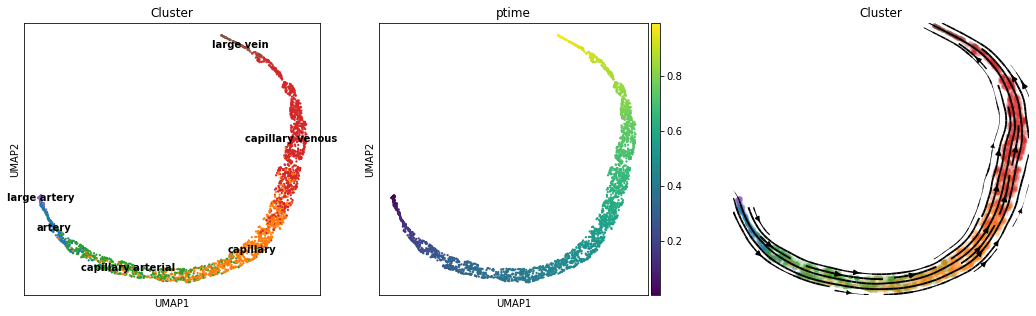

In [14]:
%matplotlib inline
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(18, 5))
sc.pl.umap(adata, color='Cluster', size=20, ax=axs[0], legend_loc='on data', show=False)
sc.pl.umap(adata, color='ptime', size=20, ax=axs[1], show=False)
sct.vf.plot_vector_field(adata, zs_key='TNODE', vf_key='VF', use_rep_neigh='TNODE', color='Cluster', ax=axs[2], legend_loc='none', frameon=False, size=100, alpha=0.2)
plt.show()  